## Rerun MSA vs. PSP machine learning with Ratios data, Full Dataset

From request [Rerun MSA vs. PSP machine learning with Ratios](https://trello.com/c/Re5D8O5Z)

Use the new data sheet [1002_Data_no_Subj_Site_Ratio.xlsx](1002_Data_no_Subj_Site_Ratio.xlsx)

## Imports and Function Definitions

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import itertools

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def plot_confusion_matrix(cm, classes=[0,1],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    plot_confusion_matrix(confusion_matrix(y_true, y_pred)) 
    print()
    get_metrics(clf.best_estimator_, Xh, yh)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[:,0].sum()

def get_weighted_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0,0]
    tp = cm[1,1]
    fp = cm[0,1]
    fn = cm[1,0]
    
    tnw = tn / (tn + fp)
    tpw = tp / (tp + fn)
    fpw = fp / (tn + fp)
    fnw = fn / (tp + fn)
    
    return tpw, fpw, fnw, tnw

def weighted_accuracy(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return (tpw + tnw) / (tpw + fpw + fnw + tnw)
    
def weighted_sensitivity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tpw / (tpw + fnw)
    
def weighted_specificity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tnw / (tnw + fpw)
    
def weighted_ppv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tpw / (tpw + fpw)

def weighted_npv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tnw / (tnw + fnw)

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model, X, y)
        print("%s\t%s" %(metric, score))

## Define classifier, pipeline and constants

In [15]:
param_grid = {
    "classifier__C": np.logspace(-5, 10, 20),
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
#     ('Norm', Normalizer()),\n",
#     ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True))
])

_cv=5
_test_size=0.20
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score),
    'weighted_sensitivity':make_scorer(weighted_sensitivity),
    'weighted_ppv':make_scorer(weighted_ppv),
    'weighted_specificity':make_scorer(weighted_specificity),
    'weighted_npv':make_scorer(weighted_npv),
    'weighted_accuracy':make_scorer(weighted_accuracy)
}

_scoring='f1_micro'
_data = pd.read_excel('1002_Data_no_Subj_Site_Ratio.xlsx')
_random_seed = 55

## 1. Control vs. PD/MSA/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.5s finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Best parameters set found on development set:

{'classifier__C': 0.08858667904100832}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.82      0.98      0.89        55
           1       0.99      0.92      0.95       146

   micro avg       0.94      0.94      0.94       201
   macro avg       0.91      0.95      0.92       201
weighted avg       0.94      0.94      0.94       201


Confusion matrix, without normalization
[[ 54   1]
 [ 12 134]]


C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



recall	0.9178082191780822
precision	0.9925925925925926
auc	0.9498132004981321
specificity	0.9818181818181818
npv	0.8181818181818182
accuracy	0.9353233830845771
weighted_sensitivity	0.9178082191780822
weighted_ppv	0.9805747738158594
weighted_specificity	0.9818181818181818
weighted_npv	0.922752808988764
weighted_accuracy	0.949813200498132


C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all conver

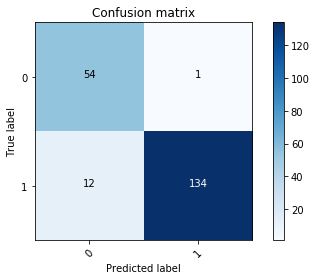

In [16]:
# Get the data
data1 = group_classes(_data, {0:0, 1:1, 2:1, 3:1})

y1 = data1['GroupID']
X1 = data1.drop(['GroupID'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size=_test_size, random_state=_random_seed)

best1 = grid_search_optimization(clf, param_grid, X_train1, Y_train1, X_test1, Y_test1, cv=_cv, scoring=_scoring)

In [17]:
scores = cross_validate(best1.best_estimator_, X_train1, Y_train1, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64

fit_time	0.12826828956604003	0.009029832369942935
score_time	0.07022929191589355	0.03796663431763397
test_recall	0.9359820089955022	0.02222731591789014
train_recall	0.962801417445046	0.005718477942903303
test_precision	0.983741363671235	0.008846014201539725
train_precision	0.99155007372497	0.0025481734397078807
test_auc	0.947839489346236	0.014629978390130598
train_auc	0.9707485211636755	0.0030747943064533727
test_specificity	0.9596969696969697	0.022149559808129576
train_specificity	0.9786956248823049	0.006538989715759823
test_npv	0.8547610722610723	0.04187830986229277
train_npv	0.9105222497034585	0.012420683143638535
test_accuracy	0.9425758818703855	0.016380436242070556
train_accuracy	0.9672264408099689	0.003579553336246489
test_weighted_sensitivity	0.9359820089955022	0.02222731591789014
train_weighted_sensitivity	0.962801417445046	0.005718477942903303
test_weighted_ppv	0.9592624012295754	0.022156665645752128
train_weighted_ppv	0.9784124360314095	0.006442741832524693
test_weighted_spec

C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


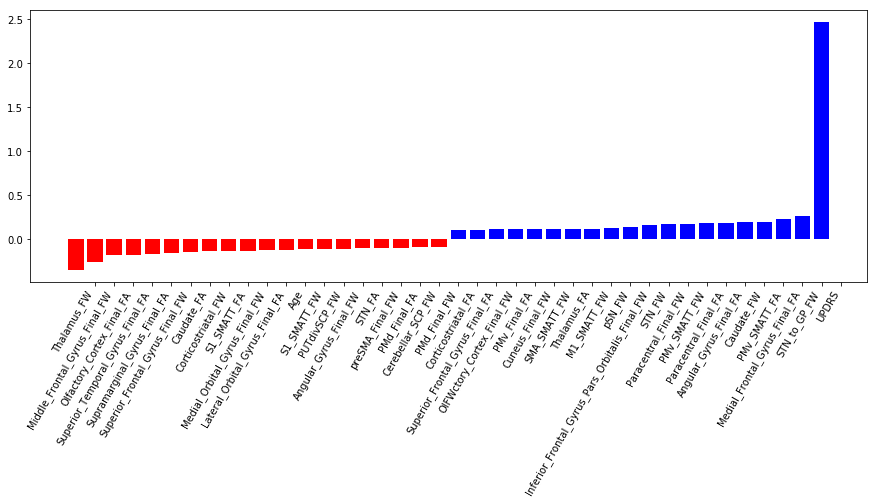

In [18]:
model = best1.best_estimator_.named_steps['classifier']
feature_names = data1.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	-0.11969046836149615
Sex	-0.0333582337681892
UPDRS	2.4607636635450376
aSN_FA	-0.026176437256382988
Caudate_FA	-0.13747863345766478
CC2_FA	0.09202892107850648
GP_FA	-0.07542270284342861
LobuleVI_FA	0.10013558535068531
LobuleV_FA	-0.08141577100223746
MCP_FA	0.02559382949837871
pSN_FA	0.09553922690333577
Putamen_FA	0.09983514813896496
SCP_FA	0.056708321857323496
STN_FA	-0.10178939506169654
Thalamus_FA	0.11831304719521143
Vermis_FA	0.02952432661421741
RN_FA	0.004556728764299369
PPN_FA	0.0058371424569148974
Dentate_FA	-0.052708312592249715
CC1_FA	-0.07004447069251679
aSN_FW	-0.026454894864555035
Caudate_FW	0.19978586032201034
CC2_FW	-0.0015784699430184729
GP_FW	-0.06736170759899114
LobuleVI_FW	0.030034776135596488
LobuleV_FW	-0.07204540723543743
MCP_FW	0.007264027076190518
pSN_FW	0.1346684615139588
Putamen_FW	0.04599040460310878
SCP_FW	0.020891570449395772
STN_FW	0.16515731701166983
Thalamus_FW	-0.3422888440403579
Vermis_FW	0.00242303414213892
RN_FW	-0.01097852689764883
PPN_FW	0.1002524

C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:405: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


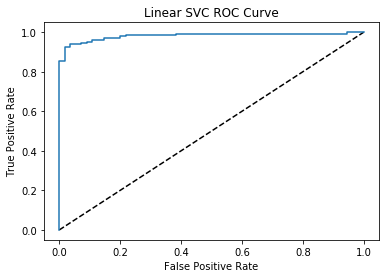

0.0 0.0
0.0 0.0410958904109589
0.0 0.8561643835616438
0.01818181818181818 0.8561643835616438
0.01818181818181818 0.9246575342465754
0.03636363636363636 0.9246575342465754
0.03636363636363636 0.9383561643835616
0.07272727272727272 0.9383561643835616
0.07272727272727272 0.9452054794520548
0.09090909090909091 0.9452054794520548
0.09090909090909091 0.952054794520548
0.10909090909090909 0.952054794520548
0.10909090909090909 0.958904109589041
0.14545454545454545 0.958904109589041
0.14545454545454545 0.9726027397260274
0.2 0.9726027397260274
0.2 0.9794520547945206
0.21818181818181817 0.9794520547945206
0.21818181818181817 0.9863013698630136
0.38181818181818183 0.9863013698630136
0.38181818181818183 0.9931506849315068
0.9454545454545454 0.9931506849315068
0.9454545454545454 1.0
1.0 1.0


In [19]:
plot_roc(best1.best_estimator_, X_test1, Y_test1)

## 2. PD vs MSA/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.1s finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\jtbri_000\Anaconda3\lib\s

Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.97      0.90      0.94       105
           1       0.79      0.93      0.85        40

   micro avg       0.91      0.91      0.91       145
   macro avg       0.88      0.91      0.89       145
weighted avg       0.92      0.91      0.91       145


Confusion matrix, without normalization
[[95 10]
 [ 3 37]]

recall	0.925
precision	0.7872340425531915
auc	0.9148809523809524
specificity	0.9047619047619048
npv	0.9693877551020408
accuracy	0.9103448275862069
weighted_sensitivity	0.925
weighted_ppv	0.9066511085180865
weighted_specificity	0.9047619047619048
weighted_npv	0.9234507897934386
weighted_accuracy	0.9148809523809525


C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all conver

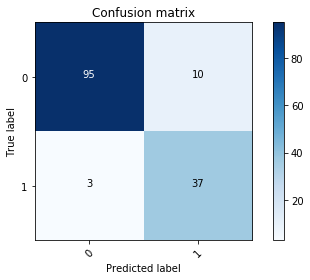

In [20]:
# Get the data
data2 = group_classes(_data, {1:0, 2:1, 3:1})

y2 = data2['GroupID']
X2 = data2.drop(['GroupID'], axis=1)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=_test_size, random_state=_random_seed)

best2 = grid_search_optimization(clf, param_grid, X_train2, Y_train2, X_test2, Y_test2, cv=_cv, scoring=_scoring)

In [21]:
scores = cross_validate(best2.best_estimator_, X_train2, Y_train2, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64

fit_time	0.06324067115783691	0.009782358926024654
score_time	0.04443325996398926	0.004521316915936256
test_recall	0.7979831932773109	0.05686934045729506
train_recall	0.8771660932123865	0.0198606714722198
test_precision	0.7875557945167453	0.06273631278324845
train_precision	0.8764411903885587	0.02087565995134116
test_auc	0.852228573452868	0.032640939131065985
train_auc	0.9121091624656426	0.010183896972741543
test_specificity	0.9064739536284252	0.03055476084577898
train_specificity	0.9470522317188983	0.01033994960686253
test_npv	0.9137160415662265	0.022955985161413676
train_npv	0.9477060033110181	0.007953076982440927
test_accuracy	0.8740128653621907	0.027573923746285086
train_accuracy	0.9261672989134448	0.008338870468456478
test_weighted_sensitivity	0.7979831932773109	0.05686934045729506
train_weighted_sensitivity	0.8771660932123865	0.0198606714722198
test_weighted_ppv	0.8956595388744344	0.033437152362909756
train_weighted_ppv	0.9432110141021361	0.010312760779300437
test_weighted_specifi

C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all conver

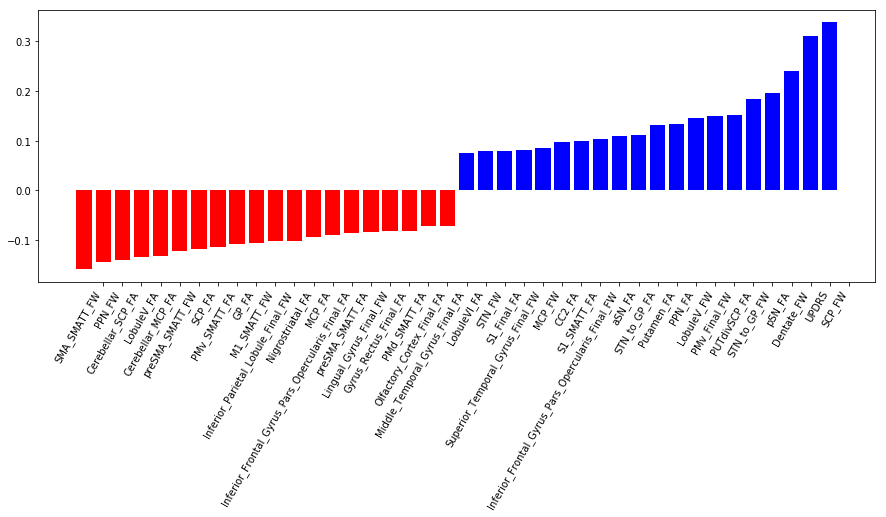

Age	-0.06176848053379424
Sex	0.0
UPDRS	0.31091761081332014
aSN_FA	0.10977971430812077
Caudate_FA	-0.03729452678682497
CC2_FA	0.09825687739624697
GP_FA	-0.10776227379135006
LobuleVI_FA	0.07605763024401634
LobuleV_FA	-0.13374080335740435
MCP_FA	-0.09318492414800794
pSN_FA	0.19630752289985115
Putamen_FA	0.13159298176888864
SCP_FA	-0.11752746648877307
STN_FA	0.05348846579623416
Thalamus_FA	-0.05034682134979607
Vermis_FA	0.07349010003526904
RN_FA	-0.02436713601877477
PPN_FA	0.13392890521461626
Dentate_FA	0.057207429218292784
CC1_FA	0.006753886789612934
aSN_FW	0.028355136266576954
Caudate_FW	0.04371311524784684
CC2_FW	-0.03485750445507327
GP_FW	0.04443861393575011
LobuleVI_FW	-0.05208665420791851
LobuleV_FW	0.14525989084677884
MCP_FW	0.08509802721202686
pSN_FW	0.021486679322116224
Putamen_FW	0.010561700753603803
SCP_FW	0.3377445576522788
STN_FW	0.07876030659377144
Thalamus_FW	0.061926970172940785
Vermis_FW	0.047426080666620955
RN_FW	-0.01612874866585763
PPN_FW	-0.1442964254917286
Dentate_FW	

In [22]:
model = best2.best_estimator_.named_steps['classifier']
feature_names = data2.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

              precision    recall  f1-score   support

           0       0.97      0.90      0.94       105
           1       0.79      0.93      0.85        40

   micro avg       0.91      0.91      0.91       145
   macro avg       0.88      0.91      0.89       145
weighted avg       0.92      0.91      0.91       145



C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:405: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


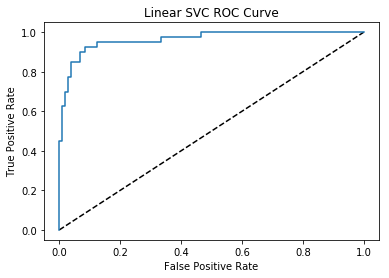

0.0 0.0
0.0 0.025
0.0 0.45
0.009523809523809525 0.45
0.009523809523809525 0.625
0.01904761904761905 0.625
0.01904761904761905 0.7
0.02857142857142857 0.7
0.02857142857142857 0.775
0.0380952380952381 0.775
0.0380952380952381 0.85
0.06666666666666667 0.85
0.06666666666666667 0.9
0.08571428571428572 0.9
0.08571428571428572 0.925
0.12380952380952381 0.925
0.12380952380952381 0.95
0.3333333333333333 0.95
0.3333333333333333 0.975
0.4666666666666667 0.975
0.4666666666666667 1.0
1.0 1.0


In [23]:
plot_roc(best2.best_estimator_, X_test2, Y_test2)

## 3. MSA vs PD/PSP

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.2s finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Best parameters set found on development set:

{'classifier__C': 0.002335721469090121}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.98      0.84      0.91       131
           1       0.36      0.86      0.51        14

   micro avg       0.84      0.84      0.84       145
   macro avg       0.67      0.85      0.71       145
weighted avg       0.92      0.84      0.87       145


Confusion matrix, without normalization
[[110  21]
 [  2  12]]

recall	0.8571428571428571
precision	0.36363636363636365
auc	0.8484187568157034
specificity	0.8396946564885496
npv	0.9821428571428571
accuracy	0.8413793103448276
weighted_sensitivity	0.8571428571428571
weighted_ppv	0.8424437299035369
weighted_specificity	0.8396946564885496
weighted_npv	0.8546059933407325
weighted_accuracy	0.8484187568157033


C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all conver

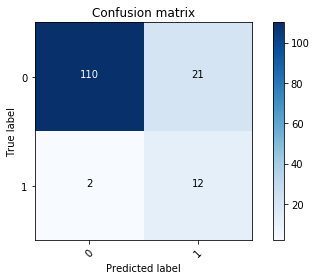

In [24]:
# Get the data
data3 = group_classes(_data, {1:0, 3:0, 2:1})

y3 = data3['GroupID']
X3 = data3.drop(['GroupID'], axis=1)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, y3, test_size=_test_size, random_state=_random_seed)

best3 = grid_search_optimization(clf, param_grid, X_train3, Y_train3, X_test3, Y_test3, cv=_cv, scoring=_scoring)

In [25]:
scores = cross_validate(best3.best_estimator_, X_train3, Y_train3, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64

fit_time	0.08850336074829102	0.00844083859066946
score_time	0.05560159683227539	0.007795387118369731
test_recall	0.7000000000000001	0.06998542122237653
train_recall	0.8	0.020824828195876086
test_precision	0.5273376623376624	0.09763386685493555
train_precision	0.6042747220666126	0.056498087007187274
test_auc	0.8038050863909921	0.030207750144259433
train_auc	0.8631612227200464	0.01620262616653321
test_specificity	0.9076101727819841	0.033341727545326647
train_specificity	0.9263224454400925	0.018724891723243476
test_npv	0.9567307323266381	0.008853171944961024
train_npv	0.9711387690940851	0.00319024850785588
test_accuracy	0.8825187406296852	0.026114660710070913
train_accuracy	0.9110486333507112	0.017482909787404032
test_weighted_sensitivity	0.7000000000000001	0.06998542122237653
train_weighted_sensitivity	0.8	0.020824828195876086
test_weighted_ppv	0.8854747524240579	0.03361752806093325
train_weighted_ppv	0.9158976008048567	0.02001248869737125
test_weighted_specificity	0.9076101727819841	0.0

C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all conver

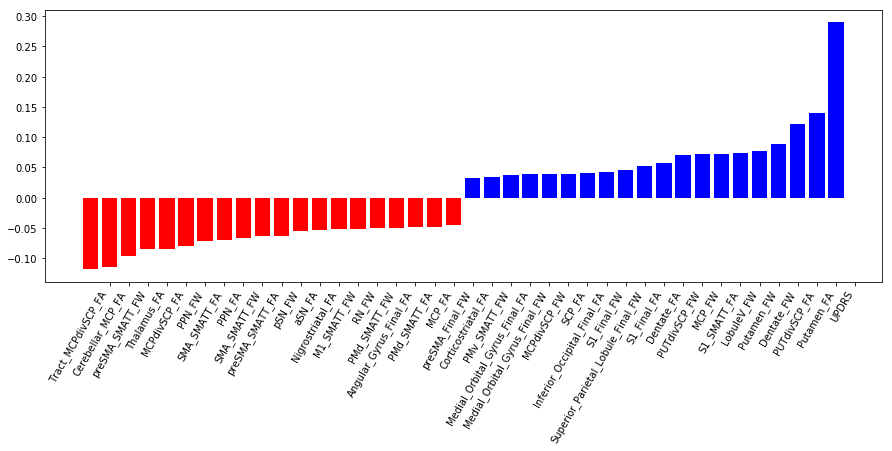

Age	-0.0002467926116537997
Sex	0.0
UPDRS	0.28987942314353216
aSN_FA	-0.055007797672598446
Caudate_FA	-0.028586137323084668
CC2_FA	0.011103777420244258
GP_FA	-0.006966560817471296
LobuleVI_FA	-0.03289799908792631
LobuleV_FA	-0.034262459190274985
MCP_FA	-0.048419016955390054
pSN_FA	-0.021206808401510374
Putamen_FA	0.13955863506751712
SCP_FA	0.03924810356747685
STN_FA	-0.027482817575580853
Thalamus_FA	-0.08482581825792337
Vermis_FA	-0.0017203937855662932
RN_FA	-0.02498745640618518
PPN_FA	-0.0697496294284642
Dentate_FA	0.057019571631652784
CC1_FA	-0.023168862796323665
aSN_FW	-0.008071476363985385
Caudate_FW	0.007550789297127165
CC2_FW	-0.029329609358069213
GP_FW	0.023173021334556676
LobuleVI_FW	0.008009635961999306
LobuleV_FW	0.0733972849050584
MCP_FW	0.07199984293898655
pSN_FW	-0.06331663414340913
Putamen_FW	0.07788528272093759
SCP_FW	0.016028267833117726
STN_FW	-0.0025054909129436156
Thalamus_FW	0.029643882249001434
Vermis_FW	0.02714854043810737
RN_FW	-0.051173576616434645
PPN_FW	-0.0791

In [26]:
model = best3.best_estimator_.named_steps['classifier']
feature_names = data3.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

              precision    recall  f1-score   support

           0       0.98      0.84      0.91       131
           1       0.36      0.86      0.51        14

   micro avg       0.84      0.84      0.84       145
   macro avg       0.67      0.85      0.71       145
weighted avg       0.92      0.84      0.87       145



C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:405: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


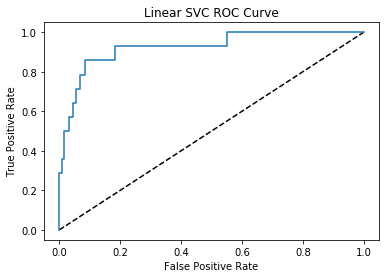

0.0 0.0
0.0 0.07142857142857142
0.0 0.2857142857142857
0.007633587786259542 0.2857142857142857
0.007633587786259542 0.35714285714285715
0.015267175572519083 0.35714285714285715
0.015267175572519083 0.5
0.030534351145038167 0.5
0.030534351145038167 0.5714285714285714
0.04580152671755725 0.5714285714285714
0.04580152671755725 0.6428571428571429
0.05343511450381679 0.6428571428571429
0.05343511450381679 0.7142857142857143
0.06870229007633588 0.7142857142857143
0.06870229007633588 0.7857142857142857
0.08396946564885496 0.7857142857142857
0.08396946564885496 0.8571428571428571
0.183206106870229 0.8571428571428571
0.183206106870229 0.9285714285714286
0.549618320610687 0.9285714285714286
0.549618320610687 1.0
1.0 1.0


In [27]:
plot_roc(best3.best_estimator_, X_test3, Y_test3)

## 4. PSP vs PD/MSA

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with inpu

Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       119
           1       0.78      0.81      0.79        26

   micro avg       0.92      0.92      0.92       145
   macro avg       0.87      0.88      0.87       145
weighted avg       0.93      0.92      0.92       145


Confusion matrix, without normalization
[[113   6]
 [  5  21]]

recall	0.8076923076923077
precision	0.7777777777777778
auc	0.8786360698125404
specificity	0.9495798319327731
npv	0.9576271186440678
accuracy	0.9241379310344827
weighted_sensitivity	0.8076923076923077
weighted_ppv	0.9412429378531073
weighted_specificity	0.9495798319327731
weighted_npv	0.8315878856495896
weighted_accuracy	0.8786360698125404


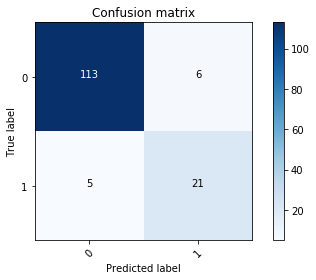

In [28]:
# Get the data
data4 = group_classes(_data, {1:0, 2:0, 3:1})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=_random_seed)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring)

In [29]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64

fit_time	0.05281291007995605	0.007287158534878252
score_time	0.036475419998168945	0.008450429473619063
test_recall	0.7966666666666666	0.0329776946536777
train_recall	0.9127240669997063	0.018881171438572764
test_precision	0.8451370851370852	0.09283793560902975
train_precision	0.8864082291117013	0.035471814598099914
test_auc	0.8815350877192982	0.024736232671454653
train_auc	0.9434907805643646	0.008063156873776211
test_specificity	0.9664035087719298	0.02143583983195721
train_specificity	0.9742574941290233	0.009332306794943897
test_npv	0.9562807855505024	0.008020497037662505
train_npv	0.9809995278043958	0.004022181983090574
test_accuracy	0.9361598687835568	0.022140880973472662
train_accuracy	0.9632940242523544	0.006582129167355004
test_weighted_sensitivity	0.7966666666666666	0.0329776946536777
train_weighted_sensitivity	0.9127240669997063	0.018881171438572764
test_weighted_ppv	0.9595222272977993	0.02563877300525323
train_weighted_ppv	0.9727527217147853	0.009284265317409203
test_weighted_sp

C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all conver

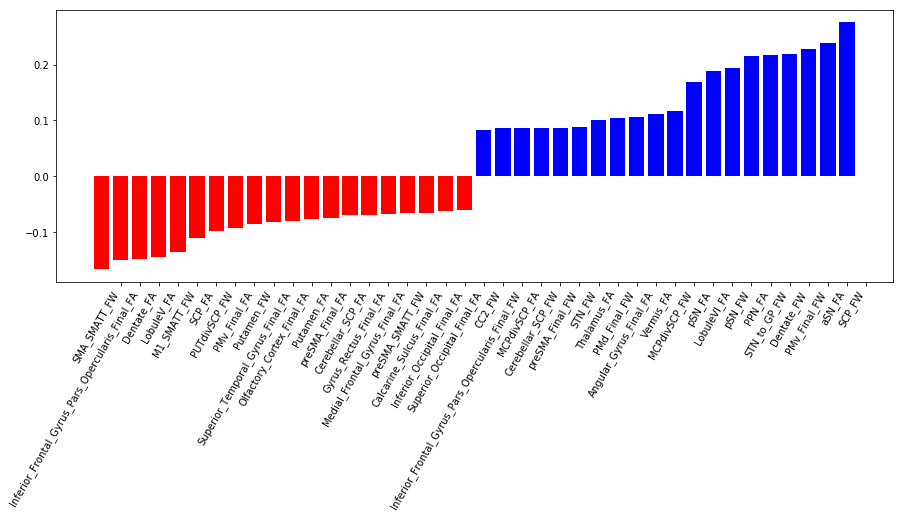

Age	0.05913610470724256
Sex	0.0
UPDRS	-0.010854148539757762
aSN_FA	0.23929969886469601
Caudate_FA	0.0031519773955292862
CC2_FA	0.0761975747486563
GP_FA	-0.014909442400196725
LobuleVI_FA	0.18922777462306303
LobuleV_FA	-0.14509777851819533
MCP_FA	-0.020576001189101314
pSN_FA	0.1680460566595585
Putamen_FA	-0.07767444040746459
SCP_FA	-0.11094071563159613
STN_FA	0.06040422333387447
Thalamus_FA	0.10076867543725077
Vermis_FA	0.1119382892084732
RN_FA	-0.04639595954804207
PPN_FA	0.21610850072543697
Dentate_FA	-0.1491009350655761
CC1_FA	0.024873554933968426
aSN_FW	0.019322274543555878
Caudate_FW	0.03893953984058769
CC2_FW	0.08182031263411456
GP_FW	-0.042008119028057476
LobuleVI_FW	-0.055038787042498094
LobuleV_FW	-8.262624495719657e-05
MCP_FW	-0.04788501566145179
pSN_FW	0.19321691464279217
Putamen_FW	-0.08625912536623656
SCP_FW	0.2761043843980279
STN_FW	0.08839493394373768
Thalamus_FW	0.04926964590342862
Vermis_FW	0.025355890666412823
RN_FW	-0.014966560930813218
PPN_FW	-0.006941687393623354
Dent

In [30]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       119
           1       0.78      0.81      0.79        26

   micro avg       0.92      0.92      0.92       145
   macro avg       0.87      0.88      0.87       145
weighted avg       0.93      0.92      0.92       145



C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:405: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


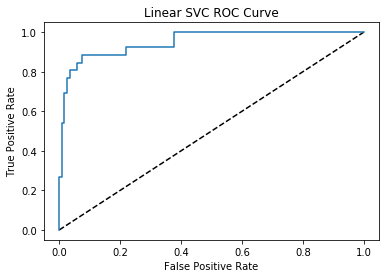

0.0 0.0
0.0 0.038461538461538464
0.0 0.2692307692307692
0.008403361344537815 0.2692307692307692
0.008403361344537815 0.5384615384615384
0.01680672268907563 0.5384615384615384
0.01680672268907563 0.6923076923076923
0.025210084033613446 0.6923076923076923
0.025210084033613446 0.7692307692307693
0.03361344537815126 0.7692307692307693
0.03361344537815126 0.8076923076923077
0.058823529411764705 0.8076923076923077
0.058823529411764705 0.8461538461538461
0.07563025210084033 0.8461538461538461
0.07563025210084033 0.8846153846153846
0.2184873949579832 0.8846153846153846
0.2184873949579832 0.9230769230769231
0.37815126050420167 0.9230769230769231
0.37815126050420167 1.0
1.0 1.0


In [31]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)

## 5. PSP (positive) vs MSA (negative)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by Standa

Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.67      0.77      0.71        13
           1       0.89      0.83      0.86        30

   micro avg       0.81      0.81      0.81        43
   macro avg       0.78      0.80      0.79        43
weighted avg       0.82      0.81      0.82        43


Confusion matrix, without normalization
[[10  3]
 [ 5 25]]

recall	0.8333333333333334
precision	0.8928571428571429
auc	0.8012820512820513
specificity	0.7692307692307693
npv	0.6666666666666666
accuracy	0.813953488372093
weighted_sensitivity	0.8333333333333334
weighted_ppv	0.783132530120482
weighted_specificity	0.7692307692307693
weighted_npv	0.8219178082191781
weighted_accuracy	0.8012820512820513


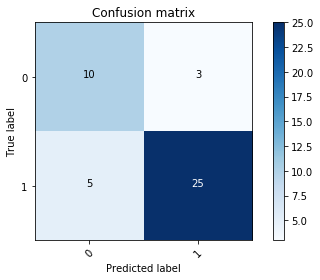

In [32]:
# Get the data
data5 = group_classes(_data, {2:0, 3:1})

y5 = data5['GroupID']
X5 = data5.drop(['GroupID'], axis=1)

X_train5, X_test5, Y_train5, Y_test5 = train_test_split(X5, y5, test_size=_test_size, random_state=_random_seed)

best5 = grid_search_optimization(clf, param_grid, X_train5, Y_train5, X_test5, Y_test5, cv=_cv, scoring=_scoring)

In [33]:
scores = cross_validate(best5.best_estimator_, X_train5, Y_train5, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64

fit_time	0.01145167350769043	0.005980159347362258
score_time	0.017064666748046874	0.0020591634694996207
test_recall	0.8389473684210526	0.07265064585735151
train_recall	0.8862974683544304	0.02676616625190068
test_precision	0.9123916408668731	0.025382564930667
train_precision	0.9808919330289193	0.013857811313912023
test_auc	0.8632832080200501	0.038222585097295904
train_auc	0.9307740474604232	0.011287846135351954
test_specificity	0.8876190476190476	0.033617833513757724
train_specificity	0.9752506265664161	0.01818770244279047
test_npv	0.8037161531279178	0.07347470346306387
train_npv	0.8612442396313365	0.025662927917743605
test_accuracy	0.8587827858416093	0.04325962052072958
train_accuracy	0.9234953007967176	0.01302134896337476
test_weighted_sensitivity	0.8389473684210526	0.07265064585735151
train_weighted_sensitivity	0.8862974683544304	0.02676616625190068
test_weighted_ppv	0.8825601298022715	0.03228876209357722
train_weighted_ppv	0.9735331037867558	0.01924696638493312
test_weighted_specifi

C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all conver

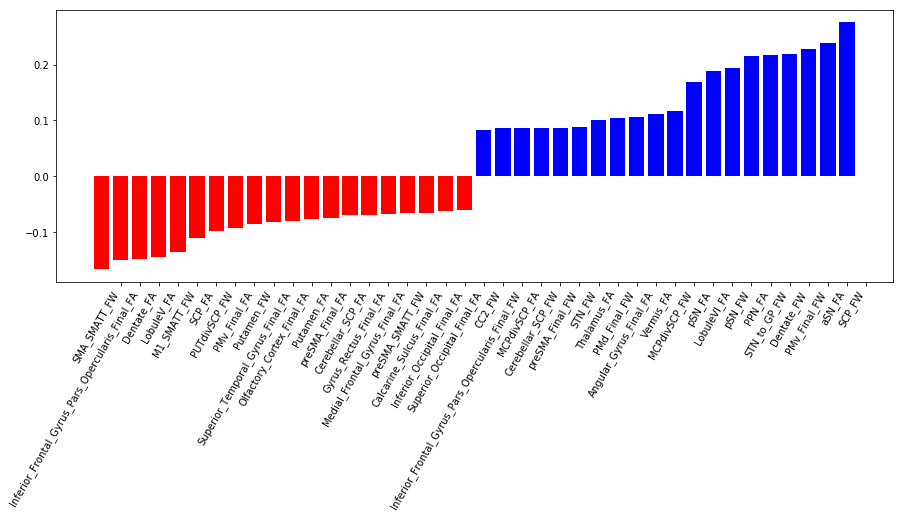

Age	0.05913610470724256
Sex	0.0
UPDRS	-0.010854148539757762
aSN_FA	0.23929969886469601
Caudate_FA	0.0031519773955292862
CC2_FA	0.0761975747486563
GP_FA	-0.014909442400196725
LobuleVI_FA	0.18922777462306303
LobuleV_FA	-0.14509777851819533
MCP_FA	-0.020576001189101314
pSN_FA	0.1680460566595585
Putamen_FA	-0.07767444040746459
SCP_FA	-0.11094071563159613
STN_FA	0.06040422333387447
Thalamus_FA	0.10076867543725077
Vermis_FA	0.1119382892084732
RN_FA	-0.04639595954804207
PPN_FA	0.21610850072543697
Dentate_FA	-0.1491009350655761
CC1_FA	0.024873554933968426
aSN_FW	0.019322274543555878
Caudate_FW	0.03893953984058769
CC2_FW	0.08182031263411456
GP_FW	-0.042008119028057476
LobuleVI_FW	-0.055038787042498094
LobuleV_FW	-8.262624495719657e-05
MCP_FW	-0.04788501566145179
pSN_FW	0.19321691464279217
Putamen_FW	-0.08625912536623656
SCP_FW	0.2761043843980279
STN_FW	0.08839493394373768
Thalamus_FW	0.04926964590342862
Vermis_FW	0.025355890666412823
RN_FW	-0.014966560930813218
PPN_FW	-0.006941687393623354
Dent

In [34]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

              precision    recall  f1-score   support

           0       0.67      0.77      0.71        13
           1       0.89      0.83      0.86        30

   micro avg       0.81      0.81      0.81        43
   macro avg       0.78      0.80      0.79        43
weighted avg       0.82      0.81      0.82        43



C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:405: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


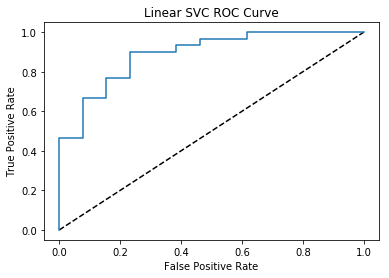

0.0 0.0
0.0 0.03333333333333333
0.0 0.4666666666666667
0.07692307692307693 0.4666666666666667
0.07692307692307693 0.6666666666666666
0.15384615384615385 0.6666666666666666
0.15384615384615385 0.7666666666666667
0.23076923076923078 0.7666666666666667
0.23076923076923078 0.9
0.38461538461538464 0.9
0.38461538461538464 0.9333333333333333
0.46153846153846156 0.9333333333333333
0.46153846153846156 0.9666666666666667
0.6153846153846154 0.9666666666666667
0.6153846153846154 1.0
1.0 1.0


In [35]:
plot_roc(best5.best_estimator_, X_test5, Y_test5)

## 6. MSA (positive) vs PSP (negative)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: 

Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.89      0.83      0.86        30
           1       0.67      0.77      0.71        13

   micro avg       0.81      0.81      0.81        43
   macro avg       0.78      0.80      0.79        43
weighted avg       0.82      0.81      0.82        43


Confusion matrix, without normalization
[[25  5]
 [ 3 10]]

recall	0.7692307692307693
precision	0.6666666666666666
auc	0.8012820512820513
specificity	0.8333333333333334
npv	0.8928571428571429
accuracy	0.813953488372093
weighted_sensitivity	0.7692307692307693
weighted_ppv	0.8219178082191781
weighted_specificity	0.8333333333333334
weighted_npv	0.783132530120482
weighted_accuracy	0.8012820512820513


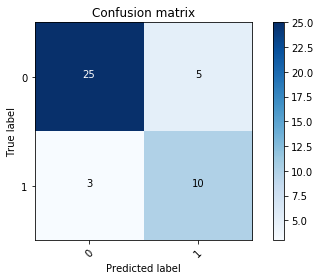

In [36]:
# Get the data
data6 = group_classes(_data, {2:1, 3:0})

y6 = data6['GroupID']
X6 = data6.drop(['GroupID'], axis=1)

X_train6, X_test6, Y_train6, Y_test6 = train_test_split(X6, y6, test_size=_test_size, random_state=_random_seed)

best6 = grid_search_optimization(clf, param_grid, X_train6, Y_train6, X_test6, Y_test6, cv=_cv, scoring=_scoring)

In [37]:
scores = cross_validate(best4.best_estimator_, X_train6, Y_train6, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64

fit_time	0.01016082763671875	0.005758727437913412
score_time	0.018924999237060546	0.004108457491048605
test_recall	0.8876190476190476	0.033617833513757724
train_recall	0.9752506265664161	0.01818770244279047
test_precision	0.8037161531279178	0.07347470346306387
train_precision	0.8585304659498207	0.026885134496584747
test_auc	0.8632832080200501	0.03822258509729597
train_auc	0.9295082246756131	0.013060961585792211
test_specificity	0.8389473684210526	0.07265064585735151
train_specificity	0.8837658227848101	0.027261441416603038
test_npv	0.9123916408668731	0.025382564930667
train_npv	0.9807777777777777	0.014039626459101782
test_accuracy	0.8587827858416093	0.04325962052072958
train_accuracy	0.9220138193152362	0.014663852621689557
test_weighted_sensitivity	0.8876190476190476	0.033617833513757724
train_weighted_sensitivity	0.9752506265664161	0.01818770244279047
test_weighted_ppv	0.8504053676363185	0.05693468004532868
train_weighted_ppv	0.8941397682444897	0.021106449282814937
test_weighted_speci

C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all conver

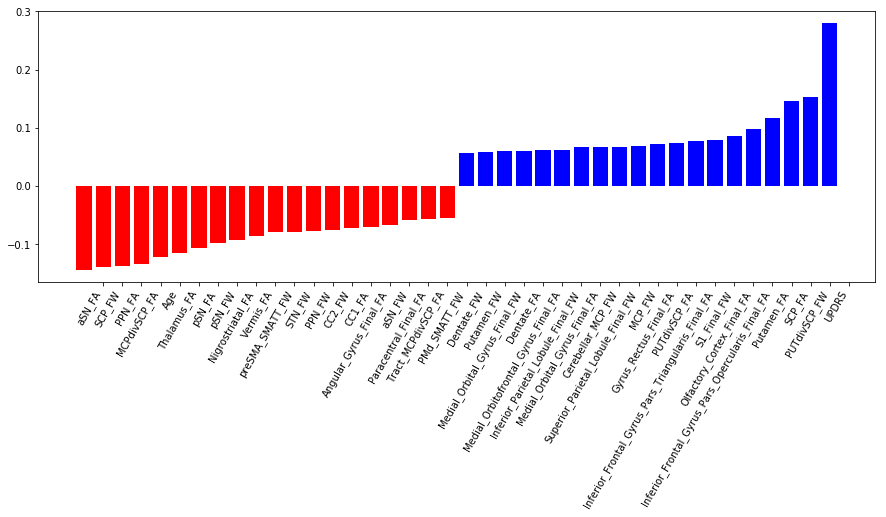

Age	-0.12075394248102307
Sex	-0.042611689893611554
UPDRS	0.2802401235884876
aSN_FA	-0.1438982882584798
Caudate_FA	-0.017793889756085306
CC2_FA	-0.012111905735647159
GP_FA	-0.020366834440803436
LobuleVI_FA	-0.03352476505467002
LobuleV_FA	0.03970467410008288
MCP_FA	-0.006361354936845663
pSN_FA	-0.10692383812680369
Putamen_FA	0.11746218545867279
SCP_FA	0.1456797794300298
STN_FA	-0.036945551816731884
Thalamus_FA	-0.11494223677655457
Vermis_FA	-0.08515359409065153
RN_FA	-0.005015366071470735
PPN_FA	-0.13736362409816047
Dentate_FA	0.06007194570319739
CC1_FA	-0.07227680426373247
aSN_FW	-0.0658600459931758
Caudate_FW	-0.01275552034677375
CC2_FW	-0.07514573435925545
GP_FW	0.05063174459726641
LobuleVI_FW	-0.026121494148861415
LobuleV_FW	0.005472710925731032
MCP_FW	0.06975737212282411
pSN_FW	-0.09782368032626179
Putamen_FW	0.05846433096190801
SCP_FW	-0.13850210647946026
STN_FW	-0.07854789956623218
Thalamus_FW	-0.043187362385303664
Vermis_FW	0.027912029381031038
RN_FW	-0.03562567783647858
PPN_FW	-

In [38]:
model = best6.best_estimator_.named_steps['classifier']
feature_names = data6.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

              precision    recall  f1-score   support

           0       0.89      0.83      0.86        30
           1       0.67      0.77      0.71        13

   micro avg       0.81      0.81      0.81        43
   macro avg       0.78      0.80      0.79        43
weighted avg       0.82      0.81      0.82        43



C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:349: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\jtbri_000\Anaconda3\lib\site-packages\imblearn\pipeline.py:405: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


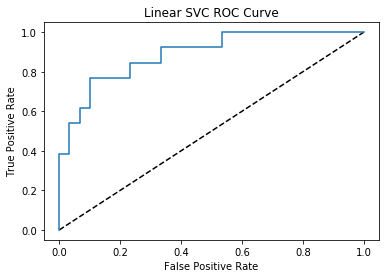

0.0 0.0
0.0 0.07692307692307693
0.0 0.38461538461538464
0.03333333333333333 0.38461538461538464
0.03333333333333333 0.5384615384615384
0.06666666666666667 0.5384615384615384
0.06666666666666667 0.6153846153846154
0.1 0.6153846153846154
0.1 0.7692307692307693
0.23333333333333334 0.7692307692307693
0.23333333333333334 0.8461538461538461
0.3333333333333333 0.8461538461538461
0.3333333333333333 0.9230769230769231
0.5333333333333333 0.9230769230769231
0.5333333333333333 1.0
1.0 1.0


In [39]:
plot_roc(best6.best_estimator_, X_test6, Y_test6)